## Imports....

In [165]:
import matplotlib.pyplot as plt
import numpy as np
import random

%env CUDA_VISIBLE_DEVICES=0
import torch
import torchvision as tv
from torchvision import datasets, transforms

from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import utils
import math

import time
import wavio

env: CUDA_VISIBLE_DEVICES=0


## Hyperparameters

In [166]:
#set up hyperparameters, net input/output sizes, and whether the problem is compressed sensing

LR = 5e-4 # learning rate
MOM = 0.9 # momentum
NUM_ITER = 1000 # number iterations
WD = 1e-4 # weight decay for l2-regularization

Z_NUM = 32 # input seed
NGF = 64 # number of filters per layer
BATCH_SIZE = 1 # batch size of gradient step
nc = 1 #num channels in the net I/0

#choose the number of samples and periods in the training waveform
WAVE_LEN = 8192
WAVE_RATE = 8192
WAVE_RES = 1 #bytes per sample

In [167]:
compressed = True
compressed_noisy = True

if compressed:
    num_measurements = 1024
else:
    num_measurements = WAVE_LEN

In [168]:
CUDA = torch.cuda.is_available()
print("On GPU: ", CUDA)

#save the correct datatype depending on CPU or GPU execution
if CUDA : 
    dtype = torch.cuda.FloatTensor  
else:
    dtype = torch.FloatTensor

On GPU:  True


## Grab the training audio wave and set Net Hyperparams

In [169]:
wave = wavio.read("sine24.wav")
WAVE_RATE = wave.rate
WAVE_LEN = wave.data.shape[0]
WAVE_RES = wave.sampwidth
nc = wave.data.shape[1]
y0 = wave.data

print("Sampling Rate: ", WAVE_RATE)
print("Num Samples: ", WAVE_LEN)
print("Clip Length: ", round(WAVE_LEN/(1.0*WAVE_RATE), 2))
print("Bits/Sample: ", 8*WAVE_RES)
print("Num Channels: ", nc)

Sampling Rate:  8192
Num Samples:  16384
Clip Length:  2.0
Bits/Sample:  16
Num Channels:  1


## Define Wave Normalisation

In [170]:
#ugly solution for maintaining wave's original image stats for normalization/renormalization 
#normalization maps wave's range: [a,b] --> [-1,1], renormalization reverses this
def get_stats(x):
    chans = x.shape[1]
    
    a = np.zeros((chans))
    b = np.zeros((chans))
    mu = np.zeros((chans))
    sigma = np.zeros((chans))
    
    for c in range(chans):
        a[c] = np.min(x[:,c])
        b[c] = np.max(x[:,c])
        mu[c] = (a+b)/2.0
        sigma[c] = (b-a)/2.0
    
    return [mu, sigma]

MU = get_stats(y0)[0]
SIGMA = get_stats(y0)[1]

def normalise(x, mean, std):
    normalised = np.zeros((x.shape))
    chans = x.shape[1]
    
    for c in range(chans):
        normalised[:,c] = (x[:,c] - mean[c])/std[c]
        
    return normalised

def renormalise(x, mean, std):
    normalised = np.zeros((x.shape))
    chans = x.data.shape[1]
    
    for c in range(chans):
        normalised[:,c] = x[:,c] * std[c] + mean[c]
        
    return normalised

print("Means: ", MU)
print("STD: ", SIGMA)

Means:  [-0.5]
STD:  [32767.5]


## Prepare Waveform for Training and Define Proper Loss

In [171]:
y = normalise(y0, MU, SIGMA)
y = torch.Tensor(y)
y = Variable(y.type(dtype))

mse = torch.nn.MSELoss().type(dtype)

## Net Topology

In [172]:
class DCGAN(nn.Module):
    def __init__(self, nz, ngf=64, output_size=1024, nc=1, num_measurements=64):
        super(DCGAN, self).__init__()
        self.nc = nc
        self.output_size = output_size

        # Deconv Layers: (in_channels, out_channels, kernel_size, stride, padding, bias = false)
        # Inputs: R^(N x Cin x Lin), Outputs: R^(N, Cout, Lout) s.t. Lout = (Lin - 1)*stride - 2*padding + kernel_size

        self.conv1 = nn.ConvTranspose1d(nz, ngf, 4, 1, 0, bias=False)
        self.bn1 = nn.BatchNorm1d(ngf)
        # LAYER 1: input: (random) zϵR^(nzx1), output: x1ϵR^(64x4) (channels x length)

        self.conv2 = nn.ConvTranspose1d(ngf, ngf, 6, 2, 2, bias=False)
        self.bn2 = nn.BatchNorm1d(ngf)
        # LAYER 2: input: x1ϵR^(64x4), output: x2ϵR^(64x8) (channels x length)

        self.conv3 = nn.ConvTranspose1d(ngf, ngf, 6, 2, 2, bias=False)
        self.bn3 = nn.BatchNorm1d(ngf)
        # LAYER 3: input: x1ϵR^(64x8), output: x2ϵR^(64x16) (channels x length)

        self.conv4 = nn.ConvTranspose1d(ngf, ngf, 6, 2, 2, bias=False)
        self.bn4 = nn.BatchNorm1d(ngf)
        # LAYER 4: input: x1ϵR^(64x16), output: x2ϵR^(64x32) (channels x length)

        self.conv5 = nn.ConvTranspose1d(ngf, ngf, 6, 2, 2, bias=False)
        self.bn5 = nn.BatchNorm1d(ngf)
        # LAYER 5: input: x2ϵR^(64x32), output: x3ϵR^(64x64) (channels x length)

        self.conv6 = nn.ConvTranspose1d(ngf, ngf, 6, 2, 2, bias=False)
        self.bn6 = nn.BatchNorm1d(ngf)
        # LAYER 6: input: x3ϵR^(64x64), output: x4ϵR^(64x128) (channels x length)

        self.conv7 = nn.ConvTranspose1d(ngf, ngf, 6, 2, 2, bias=False)
        self.bn7 = nn.BatchNorm1d(ngf)
        # LAYER 7: input: x4ϵR^(64x128), output: x5ϵR^(64x256) (channels x length)

        self.conv8 = nn.ConvTranspose1d(ngf, ngf, 6, 2, 2, bias=False)
        self.bn8 = nn.BatchNorm1d(ngf)
        # LAYER 8: input: x5ϵR^(64x256), output: x6ϵR^(64x512) (channels x length)
        
        self.conv9 = nn.ConvTranspose1d(ngf, ngf, 6, 2, 2, bias=False)
        self.bn9 = nn.BatchNorm1d(ngf)
        # LAYER 9: input: x5ϵR^(64x512), output: x6ϵR^(64x1024) (channels x length)
        
        self.conv10 = nn.ConvTranspose1d(ngf, ngf, 6, 2, 2, bias=False)
        self.bn10 = nn.BatchNorm1d(ngf)
        # LAYER 10: input: x5ϵR^(64x1024), output: x6ϵR^(64x2048) (channels x length)
        
        self.conv11 = nn.ConvTranspose1d(ngf, ngf, 6, 2, 2, bias=False)
        self.bn11 = nn.BatchNorm1d(ngf)
        # LAYER 11: input: x5ϵR^(64x2048), output: x6ϵR^(64x4096) (channels x length)
        
        self.conv12 = nn.ConvTranspose1d(ngf, ngf, 6, 2, 2, bias=False)
        self.bn12 = nn.BatchNorm1d(ngf)
        # LAYER 12: input: x5ϵR^(64x4096), output: x6ϵR^(64x8192) (channels x length)

        self.conv13 = nn.ConvTranspose1d(ngf, nc, 4, 2, 1, bias=False)  # output is image
        # LAYER 13: input: x6ϵR^(64x8192), output: (sinusoid) G(z,w)ϵR^(ncx16384) (channels x length)

        self.fc = nn.Linear(output_size * nc, num_measurements, bias=False)  # output is A; measurement matrix
        # each entry should be drawn from a Gaussian (random noisy measurements)
        # don't compute gradient of self.fc! memory issues

    def forward(self, x):
        input_size = x.size()
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.relu(self.bn4(self.conv4(x)))
        x = F.relu(self.bn5(self.conv5(x)))
        x = F.relu(self.bn6(self.conv6(x)))
        x = F.relu(self.bn7(self.conv7(x)))
        x = F.relu(self.bn8(self.conv8(x)))
        x = F.relu(self.bn9(self.conv9(x)))
        x = F.relu(self.bn10(self.conv10(x)))
        x = F.relu(self.bn11(self.conv11(x)))
        x = F.relu(self.bn12(self.conv12(x)))
        x = F.tanh(self.conv13(x))

        return x

    def measurements(self, x):
        # this gives the image - make it a single row vector of appropriate length
        y = self.forward(x).view(1, -1)
        y = y.cpu()

        # pass thru FC layer - returns A*image
        meas = self.fc(y)

        if CUDA:
            return meas.cuda()
        else:
            return meas

## Set up Net Parameters

In [173]:
start = time.time()

net = DCGAN(nz = Z_NUM, ngf = NGF, output_size = WAVE_LEN,nc = nc,num_measurements = num_measurements)
net.fc.requires_grad = False

if CUDA: 
    net.cuda()
    
# initialize fully-connected layer weights as our matrix A    
# if compressed, A_tensor: gaussian(0,1) entries in matrix of dim'n R^(num_meas x (wave_size*num_channels)) with normalized columns
# else, A = identity
if compressed:
    if compressed_noisy:
        net.fc.weight.data = (1 / math.sqrt(1.0 * num_measurements)) * torch.randn(num_measurements, WAVE_LEN * nc) #measurement matrix is normalized gaussian R^(num_measurements, wave_size*num_channels)
    else:
        kept_samples = random.sample(range(0, WAVE_LEN), num_measurements) #randomly select num_measurements samples to keep
        net.fc.weight.data = torch.eye(WAVE_LEN)[kept_samples,:] #grab rows corresponding to index of randomly kept samples from identity
        sampled_wave = np.zeros((y0.shape))
        sampled_wave[kept_samples,:] = y0[kept_samples,:]
else:
    net.fc.weight.data = torch.eye(WAVE_LEN)

allparams = [x for x in net.parameters()] #specifies which to compute gradients of
allparams = allparams[:-1] # get rid of last item in list (fc layer) because it's memory intensive

# Define input seed z as Torch variable, normalize
z = Variable(torch.zeros(BATCH_SIZE*Z_NUM).type(dtype).view(BATCH_SIZE,Z_NUM,1))
z.data.normal_().type(dtype)

# Define optimizer
optim = torch.optim.RMSprop(allparams,lr=LR,momentum=MOM, weight_decay=WD)

end = time.time()
print("Execution Time: ", round(end-start, 4), "s")

Execution Time:  0.2938 s


In [174]:
print(z.shape)
print(y.shape)

torch.Size([1, 32, 1])
torch.Size([16384, 1])


## Prepare Training Waveform for loss during Training

In [175]:
# Create measurements y, move to Torch variable
# torch.mm does matrix multiplication on a flattened row-major version of the image (R^(1)X(H*W*Ch)) and A^T (R^(H*W*Ch)X(measurements)) to produce a R^(measurements vector)
measurements = Variable(torch.mm(y.cpu().data.view(BATCH_SIZE,-1),net.fc.weight.data.permute(1,0)),requires_grad=False) 

if CUDA: # move measurements to GPU if possible
    measurements = measurements.cuda()
    
print(measurements.shape)

torch.Size([1, 1024])


## Train Wave while Tracking Loss

In [176]:
# Create numpy logs to store images, MSE values (from ground truth) for each iteration
mse_log = np.zeros((NUM_ITER))#, nc))
best_wave = np.zeros((WAVE_LEN, nc))#, nc))
cur_best_mse = 1e6
cur_best_idx = 0

start = time.time()

for i in range(NUM_ITER):
    optim.zero_grad() # clears graidents of all optimized variables
    out = net(z) # produces wave (in form of data tensor) i.e. G(z,w)
    
    loss = mse(net.measurements(z),measurements) # calculate loss between AG(z,w) and Ay
         
    # DCGAN output is in [-1,1]. Renormalise to [0,1] before plotting
    wave = out[0].detach().reshape(-1,nc).cpu()
    wave = renormalise(wave, MU, SIGMA)
    
    mse_log[i] = np.mean((normalise(y0, MU, SIGMA).reshape((1, -1)) - normalise(wave, MU, SIGMA).reshape((1, -1)))**2)
    
    if (mse_log[i] <= cur_best_mse):
        cur_best_idx = i
        cur_best_mse = mse_log[i]
        best_wave = wave
        
    if (i%20 == 0):
        print(i)
    
    if (i == NUM_ITER-1):
        wavio.write("last.wav", wave, WAVE_RATE, sampwidth=WAVE_RES)
    
    loss.backward()
    optim.step()
    
#calculate MSE between output wave and non-noisy original; and between noisy and original
True_MSE = mse_log[NUM_ITER-1]
print("Output MSE: ", round(True_MSE, 5))

end = time.time()
print("Execution Time: ", round(end-start, 2), "s")

0


/home/sravula/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:995: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


20
40
60
80
100
120
140
160
180
200
220
240
260
280
300
320
340
360
380
400
420
440
460
480
500
520
540
560
580
600
620
640
660
680
700
720
740
760
780
800
820
840
860
880
900
920
940
960
980
Output MSE:  0.0448
Execution Time:  56.74 s


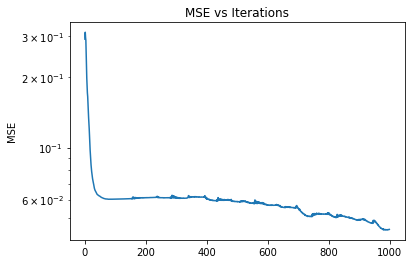

In [177]:
from matplotlib.axes import Axes

itern = np.arange(NUM_ITER)

plt.figure()
plt.ylabel('MSE')
plt.title("MSE vs Iterations")
plt.semilogy(itern, mse_log)

In [178]:
def format_e(n, dec=3, is_hparam = False): 
    a = '%E' % n
    pre = a.split('E')[0].rstrip('0').rstrip('.')
    pre = str(round(float(pre), dec))
    if is_hparam == True:
        pre = str(int(float(pre))) # get rid of decimal
    return pre + 'e' + a.split('E')[1]

print("Best MSE: ", str(format_e(cur_best_mse)))
print("Best index: ", cur_best_idx)
wavio.write("best.wav", best_wave, WAVE_RATE, sampwidth=WAVE_RES)

Best MSE:  4.458e-02
Best index:  993
